## Library

In [1]:
import math
import random
import squigglepy as sq
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
%matplotlib inline

exec(open('library.py').read())
print('Loaded 2')

STATES = ['boring', 'xrisk_tai_misuse', 'aligned_tai', 'xrisk_full_unaligned_tai_extinction',
          'xrisk_full_unaligned_tai_singleton', 'xrisk_subtly_unaligned_tai', 'xrisk_unknown_unknown',
          'xrisk_nanotech', 'xrisk_nukes_war', 'xrisk_nukes_accident', 'xrisk_bio_accident', 'xrisk_bio_war',
          'xrisk_bio_nonstate']

def print_states(collector):
    c = Counter([r[0]['category'] for r in collector])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c

print('Loaded 3')

Loaded 2
Loaded 3


## Variables (customize these)

In [2]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)
CREDIBLE_INTERVAL = 0.9                           # CIs are 90% CIs


# This is a PDF for when TAI will be available to be developed. Look to `When TAI?` notebook to generate this.
tai_pdf = [0.0044, 0.003 , 0.005 , 0.0079, 0.0097, 0.0138, 0.0148, 0.0166,
       0.0239, 0.0224, 0.0238, 0.0247, 0.0255, 0.0267, 0.0276, 0.027 ,
       0.0252, 0.028 , 0.0259, 0.0221, 0.0209, 0.0215, 0.0217, 0.0229,
       0.0204, 0.0201, 0.0203, 0.017 , 0.0204, 0.0166, 0.0174, 0.0155,
       0.0145, 0.0129, 0.0131, 0.0121, 0.0106, 0.0116, 0.0112, 0.0088,
       0.0086, 0.0083, 0.0076, 0.0084, 0.0068, 0.0077, 0.0058, 0.0062,
       0.0058, 0.0061, 0.0063, 0.0058, 0.0056, 0.0059, 0.0056, 0.0048,
       0.0046, 0.0038, 0.0044, 0.0041, 0.0038, 0.0037, 0.0033, 0.0031,
       0.0026, 0.0025, 0.0023, 0.0027, 0.0019, 0.003 , 0.0024, 0.0019,
       0.003 , 0.0013, 0.002 , 0.0028, 0.0012, 0.0017, 0.0013, 0.0016,
       0.0019, 0.0018, 0.0014, 0.0012, 0.0016, 0.0021, 0.0018, 0.0009,
       0.0011, 0.0012, 0.0012, 0.0012, 0.0008, 0.0004, 0.0011, 0.0006,
       0.0008, 0.001 , 0.0012, 0.0007, 0.0007, 0.0003, 0.0006, 0.0007,
       0.0006, 0.0005, 0.0003, 0.0003, 0.0003, 0.0013, 0.0007, 0.0006,
       0.0008, 0.0008, 0.0007, 0.0003, 0.0005, 0.0002, 0.0006, 0.0001,
       0.0003, 0.0003, 0.0003, 0.0011, 0.0003, 0.0002, 0.0003, 0.0004,
       0.0002, 0.0006, 0.0001, 0.    , 0.0007, 0.0002, 0.0005, 0.0006,
       0.0006, 0.0002, 0.0002, 0.0003, 0.0004, 0.0002, 0.0001, 0.0003,
       0.0002, 0.0004, 0.0005, 0.0006, 0.0003, 0.0003, 0.    , 0.0001,
       0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.    , 0.0002, 0.0008,
       0.0006, 0.0003, 0.    , 0.0004, 0.0003, 0.0005, 0.0001, 0.0004,
       0.0001, 0.0003, 0.0001, 0.0003, 0.0001, 0.    , 0.0001, 0.0005,
       0.0004, 0.0004, 0.0003, 0.0005, 0.0002, 0.    , 0.0003, 0.0004,
       0.0003, 0.0006, 0.0004, 0.0002, 0.0003, 0.0004, 0.0001, 0.0002,
       0.0001, 0.0002, 0.0001, 0.0002, 0.    , 0.0002, 0.0003, 0]
tai_pdf = np.array(tai_pdf)

# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making agentic TAI, will it be aligned by default?
p_tai_aligned_by_default = 0.30

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(war, year, first_attempt=True, print_diagnostic=False):
    if first_attempt:
        p = min(0.05 + 1.2 * (year/40), 0.7)
    else:
        p = min(0.05 + 1.5 * (year/40), 0.85)
    if war:
        p = p * 0.6
    if print_diagnostic:
        print('* alignment diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
# TODO: Convert to logistic curves

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved = 0.9

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved_if_aligned_by_default = 0.65

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
p_full_tai_misalignment_averted = 0.2

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
p_tai_misalignment_averting_is_catastrophic = 0.1

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
p_full_tai_misalignment_averted_means_abandoned_tai = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
p_tai_xrisk_is_extinction = 0.2

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
p_tai_singleton_is_catastrophic = 0.7

# What is the chance in a given year there will be a great power war?
def p_great_power_war(year):
    if year < 2025:
        return 0.006
    elif year < 2030:
        return 0.006 + 0.3*0.01*0.2
    elif year < 2040:
        return 0.006 + 0.002 + 0.05*0.01*0.2
    else:
        return (0.006 + 0.05*0.05*0.2) * (0.99 ** year)

# Conditional on a great power war starting, how long will it last?
war_length = sq.lognorm(2, 50) # 90% CI

# TODO: There should be a small chance of catastrophe and x-risk from great power war, absent nuclear or bio pathway
# TODO: There should be a chance of nukes-related catastrophe and x-risk from breaking nuclear symmetry

# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.06 if war else 0.02
    p = p * (0.998 ** year)
    return p
# TODO: Graph

# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05

# Conditional on a nuclear exchange, what is the chance it escalates into a xrisk?
def p_xrisk_from_nuclear_exchange(war):
    p = 0.8 if war else 0.6
    p = p * 0.2 * 0.2
    return p
    # TODO: maybe also change arsenal size over time?
    
# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (but not an xrisk)?
def p_catastrophe_from_nuclear_exchange(war):
    p = 0.8 if war else 0.6
    return p
    # TODO: maybe also change arsenal size over time?

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year):
    return 0.0005 * (0.985 ** year)
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    return 0.01 if war else 0.003

# Conditional on a accidental biorisk, what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio(year):
    p = 0.2 * 0.2 * 0.2
    p = p * (0.99 ** year)
    return p
# TODO: Graph
    
# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
p_nuclear_war_given_war = 0.05

# Conditional on a great power war, what is the chance it intentionally results in a bioweapon?
p_biowar_given_war = 0.01

# What is the chance of a non-state actor creating an intentional biorisk?
p_nonstate_bio = 0.005

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
p_natural_bio_is_catastrophe = 0.1

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
p_engineered_bio_is_catastrophe = 0.1

# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_intentional_bio(year):
    p = 0.2 * 0.2
    p = p * (0.995 ** year)
    return p
# TODO: Graph

# Wha is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1
# TODO: Graph

# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1

# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return 0.0001 / (0.99 ** year) # TODO: This goes over 1
# TODO: Graph
    

# ------------- Ignore below here ------------
years = list(range(CURRENT_YEAR, MAX_YEAR))
print('Loaded')

Loaded


## TAI Timelines

Text(0, 0.5, 'chance of TAI IN year')

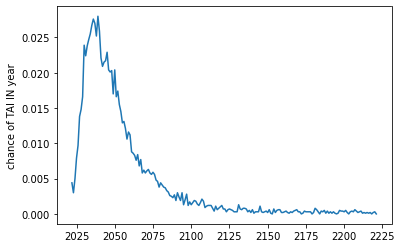

In [3]:
plt.plot(years, tai_pdf)
plt.ylabel('chance of TAI IN year')


Text(0, 0.5, 'chance of TAI BY year')

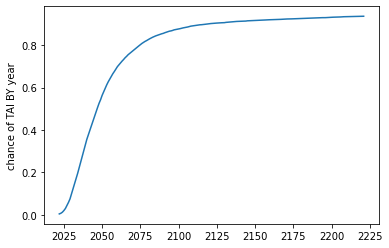

In [4]:
tai_cdf = np.cumsum(tai_pdf)
plt.plot(years, tai_cdf)
plt.ylabel('chance of TAI BY year')


## Chance of Solving Alignment by Year (Conditional on TAI in that year)

Text(0, 0.5, 'chance of solving alignment if TAI in year')

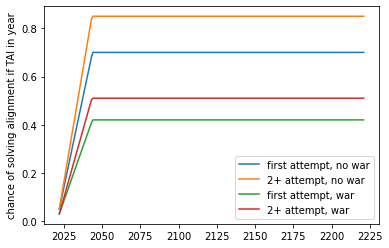

In [5]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
alignment_pwar = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2war = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt, no war')
plt.plot(years, alignment_p2, label='2+ attempt, no war')
plt.plot(years, alignment_pwar, label='first attempt, war')
plt.plot(years, alignment_p2war, label='2+ attempt, war')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
# TODO: Make logistic?

In [6]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with no war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_p[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment with no war 5.0% (2nd attempt 5.0%)
Year: 2023 - chance of solving TAI alignment with no war 8.0% (2nd attempt 9.0%)
Year: 2024 - chance of solving TAI alignment with no war 11.0% (2nd attempt 12.0%)
Year: 2025 - chance of solving TAI alignment with no war 14.0% (2nd attempt 16.0%)
Year: 2026 - chance of solving TAI alignment with no war 17.0% (2nd attempt 20.0%)
Year: 2027 - chance of solving TAI alignment with no war 20.0% (2nd attempt 24.0%)
Year: 2028 - chance of solving TAI alignment with no war 23.0% (2nd attempt 27.0%)
Year: 2029 - chance of solving TAI alignment with no war 26.0% (2nd attempt 31.0%)
Year: 2030 - chance of solving TAI alignment with no war 29.0% (2nd attempt 35.0%)
Year: 2031 - chance of solving TAI alignment with no war 32.0% (2nd attempt 39.0%)
Year: 2032 - chance of solving TAI alignment with no war 35.0% (2nd attempt 42.0%)
Year: 2033 - chance of solving TAI alignment with no war 38.0% (2nd attempt 46.0%)
Year: 20

In [7]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_pwar[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2war[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment with war 3.0% (2nd attempt 3.0%)
Year: 2023 - chance of solving TAI alignment with war 5.0% (2nd attempt 5.0%)
Year: 2024 - chance of solving TAI alignment with war 7.0% (2nd attempt 8.0%)
Year: 2025 - chance of solving TAI alignment with war 8.0% (2nd attempt 10.0%)
Year: 2026 - chance of solving TAI alignment with war 10.0% (2nd attempt 12.0%)
Year: 2027 - chance of solving TAI alignment with war 12.0% (2nd attempt 14.0%)
Year: 2028 - chance of solving TAI alignment with war 14.0% (2nd attempt 16.0%)
Year: 2029 - chance of solving TAI alignment with war 16.0% (2nd attempt 19.0%)
Year: 2030 - chance of solving TAI alignment with war 17.0% (2nd attempt 21.0%)
Year: 2031 - chance of solving TAI alignment with war 19.0% (2nd attempt 23.0%)
Year: 2032 - chance of solving TAI alignment with war 21.0% (2nd attempt 26.0%)
Year: 2033 - chance of solving TAI alignment with war 23.0% (2nd attempt 28.0%)
Year: 2034 - chance of solving TAI alignment wi

## Great Power War

Text(0, 0.5, 'chance of great power war IN year')

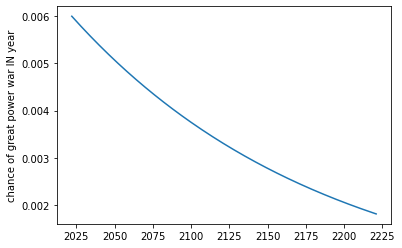

In [8]:
war_pdf = np.array([p_great_power_war(y - CURRENT_YEAR) for y in years])
war_pdf = [war_pdf[0] if x == 0 else war_pdf[x] * np.prod(1 - war_pdf[:x]) for x in range(MAX_YEAR - CURRENT_YEAR)]
plt.plot(years, war_pdf)
plt.ylabel('chance of great power war IN year')


Text(0, 0.5, 'chance of great power war BY year')

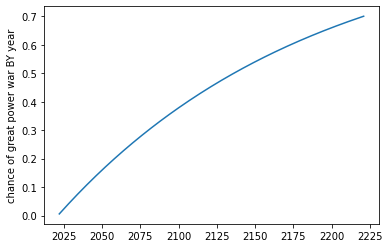

In [9]:
war_cdf = np.cumsum(war_pdf)
plt.plot(years, war_cdf)
plt.ylabel('chance of great power war BY year')


In [10]:
for y in years:
    print('Year: {} - chance of war IN year {}%, BY year {}%'.format(y,
                                                                     np.round(war_pdf[y - CURRENT_YEAR] * 100, 1),
                                                                     np.round(war_cdf[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - chance of war IN year 0.6%, BY year 0.6%
Year: 2023 - chance of war IN year 0.6%, BY year 1.2%
Year: 2024 - chance of war IN year 0.6%, BY year 1.8%
Year: 2025 - chance of war IN year 0.6%, BY year 2.4%
Year: 2026 - chance of war IN year 0.6%, BY year 3.0%
Year: 2027 - chance of war IN year 0.6%, BY year 3.5%
Year: 2028 - chance of war IN year 0.6%, BY year 4.1%
Year: 2029 - chance of war IN year 0.6%, BY year 4.7%
Year: 2030 - chance of war IN year 0.6%, BY year 5.3%
Year: 2031 - chance of war IN year 0.6%, BY year 5.8%
Year: 2032 - chance of war IN year 0.6%, BY year 6.4%
Year: 2033 - chance of war IN year 0.6%, BY year 7.0%
Year: 2034 - chance of war IN year 0.6%, BY year 7.5%
Year: 2035 - chance of war IN year 0.6%, BY year 8.1%
Year: 2036 - chance of war IN year 0.6%, BY year 8.6%
Year: 2037 - chance of war IN year 0.5%, BY year 9.2%
Year: 2038 - chance of war IN year 0.5%, BY year 9.7%
Year: 2039 - chance of war IN year 0.5%, BY year 10.3%
Year: 2040 - chance of war 

In [11]:
war_length_p = sq.get_percentiles(sq.sample(war_length, credibility=CREDIBLE_INTERVAL, n=1000), reverse=True)
war_length_p

{99: 0.8937620250474607,
 95: 2.083208202982393,
 90: 3.013671926558882,
 80: 4.469819548551468,
 70: 5.907495009299875,
 60: 7.848896347512842,
 50: 10.26014923738138,
 40: 13.526460445596465,
 30: 17.35588133816234,
 20: 24.29634709743871,
 10: 39.77730083818089,
 5: 61.08961756748923,
 1: 151.79983577618955}

## Run Model

In [12]:
def p_tai_occurs_in(year):
    if year < 0:
        raise ValueError
    elif year == 0:
        return tai_pdf[0]
    else:
        return tai_pdf[year] / (1 - sum(tai_pdf[y] for y in range(year)))
    

collectors = {}
collect_years = [2022, 2024, 2030, 2035, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2150, 2200]
for y in collect_years:
    collectors[y] = []

results = []
print('Loaded')
print('-')

for r in range(RUNS):
    print_diagnostic = r < 30
    if print_diagnostic or r % 500 == 0 or r == RUNS - 1:
        print('## RUN {}/{} ##'.format(r + 1, RUNS))
    terminate = False; terminate_y = None
    state = {'category': 'boring', 'tai': False, 'tai_type': None, 'nano': False, 'war': False,
             'engineered_pathogen': False, 'natural_pathogen': False, 'averted_misalignment': False,
             'nuclear_weapon_used': False, 'catastrophe': []}
    
    for y in years:
        if not terminate:

            ## TAI Scenarios
            if (not terminate and state['tai_type'] != 'abandoned' and state['tai_type'] != 'tool' and
                (sq.event_occurs(p_tai_occurs_in(y - CURRENT_YEAR)) or state['tai'])):
                # TODO: Slow vs. fast takeoff
                # TODO: May not deploy TAI as soon as it is deployable
                if (sq.event_occurs(p_make_agent_tai) or state['tai_type'] == 'agent') and state['tai_type'] != 'tool':
                    # TODO: Do we want to re-roll the possibility of making agentic TAI in future years?
                    if sq.event_occurs(p_tai_intentional_misuse(state['war'])):
                        if sq.event_occurs(p_full_tai_misalignment_averted):
                            state['averted_misalignment'] = True
                            if sq.event_occurs(p_tai_misalignment_averting_is_catastrophic):
                                # TODO: Right now this guarantees abandonment if catastrophe - revise?
                                if print_diagnostic:
                                    print('{}: ...Intentional misuse of TAI happened, was averted with catastrophe, and we abandon TAI'.format(y))
                                state['tai'] = True; state['tai_type'] = 'abandoned'
                                state['catastrophe'].append('averting_intentional_tai')
                                # TODO: Maybe resume TAI with lower chance of happening?
                            elif sq.event_occurs(p_full_tai_misalignment_averted_means_abandoned_tai):
                                if print_diagnostic:
                                    print('{}: ...Intentional misuse of TAI happened, it was averted with no catastrophe, and we abandon TAI'.format(y))
                                state['tai'] = True; state['tai_type'] = 'abandoned'    
                                # TODO: Maybe resume TAI with lower chance of happening?
                            elif print_diagnostic:
                                print('{}: ...Intentional misuse of TAI happened, but it was averted'.format(y))
                        else:
                            if print_diagnostic:
                                print('{}: ...XRISK from intentional misuse of TAI (singleton) :('.format(y))
                            state['category'] = 'xrisk_tai_misuse'; state['tai'] = True; state['tai_type'] = 'agent'
                            if sq.event_occurs(p_tai_singleton_is_catastrophic):
                                if print_diagnostic:
                                    print('...Singleton is catastrophic')
                                state['catastrophe'].append(state['category'])
                            terminate = True; terminate_y = y
                    elif sq.event_occurs(p_alignment_solved(state['war'], y - CURRENT_YEAR, first_attempt=not state['tai'], print_diagnostic=print_diagnostic)):
                        if sq.event_occurs(p_subtle_alignment_solved):
                            if print_diagnostic:
                                print('{}: ...Achieved aligned TAI (aligned via work, {} attempt), happy future! :D'.format(y, '2nd+' if state['tai'] else 'first'))
                            state['category'] = 'aligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                            terminate = True; terminate_y = y
                        else:
                            if print_diagnostic:
                                print('{}: ...XRISK from subtly unaligned TAI :('.format(y))
                            state['category'] = 'xrisk_subtly_unaligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                            terminate = True; terminate_y = y
                    elif sq.event_occurs(p_tai_aligned_by_default):
                        if sq.event_occurs(p_subtle_alignment_solved_if_aligned_by_default):
                            if print_diagnostic:
                                print('{}: ...Achieved aligned TAI (aligned by default), happy future! :D'.format(y))
                            state['category'] = 'aligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                            terminate = True; terminate_y = y
                            # TODO: Does aligned TAI make all other xrisks impossible? We currently assume it does
                                # TODO: Maybe introduce takeoff delay before other xrisks become impossible?
                        else:
                            if print_diagnostic:
                                print('{}: ...XRISK from subtly unaligned TAI :('.format(y))
                            state['category'] = 'xrisk_subtly_unaligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                            terminate = True; terminate_y = y
                    elif sq.event_occurs(p_full_tai_misalignment_averted):
                        state['averted_misalignment'] = True
                        if sq.event_occurs(p_tai_misalignment_averting_is_catastrophic):
                            # TODO: Right now this guarantees abandonment if catastrophe - revise?
                            if print_diagnostic:
                                print('{}: ...Misaligned TAI happened, it was averted with catastrophe, and we abandon TAI'.format(y))
                            state['tai'] = True; state['tai_type'] = 'abandoned'
                            state['catastrophe'].append('averting_misaligned_tai')
                            # TODO: Maybe resume TAI with lower chance of happening?
                        elif sq.event_occurs(p_full_tai_misalignment_averted_means_abandoned_tai):
                            if print_diagnostic:
                                print('{}: ...Misaligned TAI happened, it was averted with no catastrophe, and we abandon TAI'.format(y))
                            state['tai'] = True; state['tai_type'] = 'abandoned'    
                            # TODO: Maybe resume TAI with lower chance of happening?
                        elif print_diagnostic:
                            print('{}: ...Misaligned TAI happened, but it was averted'.format(y))
                            state['tai'] = True; state['tai_type'] = 'agent'
                    elif sq.event_occurs(p_tai_xrisk_is_extinction):
                        if print_diagnostic:
                            print('{}: ...XRISK from fully unaligned TAI (extinction) :('.format(y))
                        state['category'] = 'xrisk_full_unaligned_tai_extinction'; state['tai'] = True; state['tai_type'] = 'agent'
                        state['catastrophe'].append(state['category'])
                        terminate = True; terminate_y = y
                    else:
                        if print_diagnostic:
                            print('{}: ...XRISK from fully unaligned TAI (singleton) :('.format(y))
                        state['category'] = 'xrisk_full_unaligned_tai_singleton'; state['tai'] = True; state['tai_type'] = 'agent'
                        if sq.event_occurs(p_tai_singleton_is_catastrophic):
                            if print_diagnostic:
                                print('...Singleton is catastrophic')
                            state['catastrophe'].append(state['category'])
                        terminate = True; terminate_y = y
                else: # tool TAI
                    if print_diagnostic:
                        print('{}: ...Tool TAI made'.format(y))
                    state['tai'] = True; state['tai_type'] = 'tool'
                    # TODO: Does tool AI help mitigate xrisk?
                    
            # TODO: TAI or nearness to TAI creates great power war
                                   
            ## Great power war scenarios
            if not terminate and (sq.event_occurs(p_great_power_war(y - CURRENT_YEAR)) and not state['war']):
                if print_diagnostic:
                    print('{}: WAR!!!'.format(y))
                state['war'] = True
                war_end_year = sq.sample(war_length, credibility=CREDIBLE_INTERVAL) + y
            
            if state['war'] and (y >= war_end_year or state['category'] == 'aligned_tai'):
                if print_diagnostic:
                    print('{}: War ends :)'.format(y))
                state['war'] = False

            
            ## Nuclear scenarios
            if not terminate and sq.event_occurs(p_nuclear_accident(state['war'], y - CURRENT_YEAR)):
                state['nuclear_weapon_used'] = True
                if sq.event_occurs(p_nuclear_accident_becomes_exchange(state['war'])):
                    if sq.event_occurs(p_catastrophe_from_nuclear_exchange(state['war'])):
                        if print_diagnostic:
                            print('{}: ...catastrophe from nukes (accidental exchange)'.format(y))
                        state['catastrophe'].append('nukes_accident')
                    if sq.event_occurs(p_xrisk_from_nuclear_exchange(state['war'])):
                        if print_diagnostic:
                            print('{}: ...XRISK from nukes (accidental exchange) :('.format(y))
                        state['category'] = 'xrisk_nukes_accident'
                        terminate = True; terminate_y = y

            if not terminate and state['war'] and sq.event_occurs(p_nuclear_war_given_war):
                state['nuclear_weapon_used'] = True
                if sq.event_occurs(p_catastrophe_from_nuclear_exchange(state['war'])):
                    if print_diagnostic:
                        print('{}: ...catastrophe from nukes (war)'.format(y))
                    state['catastrophe'].append('nukes_war')
                if sq.event_occurs(p_xrisk_from_nuclear_exchange(state['war'])):
                    if print_diagnostic:
                        print('{}: ...XRISK from nukes (war) :('.format(y))
                    state['category'] = 'xrisk_nukes_war'
                    terminate = True; terminate_y = y
            
                                      
            ## Bio scenarios
            if not terminate and sq.event_occurs(p_natural_bio(y - CURRENT_YEAR)):
                state['natural_pathogen'] = True
                if sq.event_occurs(p_natural_bio_is_catastrophe):
                    if print_diagnostic:
                        print('{}: ...catastrophe from natural pathogen'.format(y))
                    state['catastrophe'].append('natural_pathogen')

            if not terminate and sq.event_occurs(p_accidental_bio(state['war'])):
                state['engineered_pathogen'] = True
                if sq.event_occurs(p_xrisk_from_accidental_bio(y - CURRENT_YEAR)):
                    if print_diagnostic:
                        print('{}: ...XRISK from pathogen (lab-leak) :('.format(y))
                    state['category'] = 'xrisk_bio_accident'
                    terminate = True; terminate_y = y
                elif sq.event_occurs(p_engineered_bio_is_catastrophe): # TODO: Make catastrophe and then x-risk|catastrophe
                    if print_diagnostic:
                        print('{}: ...catastrophe from lab-leak pathogen'.format(y))
                    state['catastrophe'].append('engineered_pathogen')
                
                    
            if not terminate and sq.event_occurs(p_nonstate_bio):
                state['engineered_pathogen'] = True
                if sq.event_occurs(p_xrisk_from_intentional_bio(y - CURRENT_YEAR)):
                    if print_diagnostic:
                        print('{}: ...XRISK from pathogen (nonstate actor) :('.format(y))
                    state['category'] = 'xrisk_bio_nonstate'
                    terminate = True; terminate_y = y
                elif sq.event_occurs(p_engineered_bio_is_catastrophe): # TODO: Make catastrophe and then x-risk|catastrophe
                    if print_diagnostic:
                        print('{}: ...catastrophe from engineered pathogen (nonstate)'.format(y))
                    state['catastrophe'].append('engineered_pathogen')
                    
            if not terminate and state['war'] and sq.event_occurs(p_biowar_given_war):
                state['engineered_pathogen'] = True
                if sq.event_occurs(p_xrisk_from_intentional_bio(y - CURRENT_YEAR)):
                    if print_diagnostic:
                        print('{}: ...XRISK from pathogen (war) :('.format(y))
                    state['category'] = 'xrisk_bio_war'
                    terminate = True; terminate_y = y
                elif sq.event_occurs(p_engineered_bio_is_catastrophe):
                    if print_diagnostic:
                        print('{}: ...catastrophe from engineered pathogen (state)'.format(y))
                    state['catastrophe'].append('engineered_pathogen')
            
            
            ## Nanotech scenarios
            if not terminate and sq.event_occurs(p_nanotech_possible(y - CURRENT_YEAR)) and not state['nano']:
                state['nano'] = True
                if sq.event_occurs(p_nanotech_is_xrisk):
                    if print_diagnostic:
                        print('{}: ...XRISK from nanotech :('.format(y))
                    state['category'] = 'xrisk_nanotech'
                    state['catastrophe'].append(state['category'])
                    terminate = True; terminate_y = y
            # TODO: Catastrophic but non x-risk nano?
            # TODO: catastrophe or nano x-risk but not in the first year?
            
            
            ## "Unknown unknown" scenarios
            if not terminate and sq.event_occurs(p_unknown_unknown_xrisk(y - CURRENT_YEAR)):
                if print_diagnostic:
                    print('{}: ...XRISK from unknown unknown'.format(y))
                state['category'] = 'xrisk_unknown_unknown'
                state['catastrophe'].append(state['category'])
                # TODO: What % of "unknown unknowns" are extinction?
                # TODO: catastrophic but not x-risk unknown unknowns?
                terminate = True; terminate_y = y
    
    
        ## Run collectors
        for y_c in collect_years:
            if y == y_c:
                collectors[y_c].append([deepcopy(state), terminate_y])
                
    ## Boring future if MAX_YEAR is reached with no termination
    if not terminate:
        if print_diagnostic:
            print('...Boring future')
        terminate_y = y

    if print_diagnostic:
        print('-')
        print('-')

Loaded
-
## RUN 1/10000 ##
* alignment diagnostic - war: False year: 94 first attempt: True -> p 0.7)
2116: ...XRISK from subtly unaligned TAI :(
-
-
## RUN 2/10000 ##
* alignment diagnostic - war: False year: 7 first attempt: True -> p 0.26)
2029: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
## RUN 3/10000 ##
2030: WAR!!!
2033: War ends :)
* alignment diagnostic - war: False year: 34 first attempt: True -> p 0.7)
2056: ...Achieved aligned TAI (aligned via work, first attempt), happy future! :D
-
-
## RUN 4/10000 ##
2046: ...XRISK from intentional misuse of TAI (singleton) :(
...Singleton is catastrophic
-
-
## RUN 5/10000 ##
2132: WAR!!!
2156: War ends :)
...Boring future
-
-
## RUN 6/10000 ##
2048: ...Tool TAI made
...Boring future
-
-
## RUN 7/10000 ##
* alignment diagnostic - war: False year: 12 first attempt: True -> p 0.41)
2034: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
## RUN 8/10000 ##
* alignment diagn

In [13]:
print('0. World State At Year')
for y_c in collect_years:
    print('## {} ##'.format(y_c))  
    pprint(print_states(collectors[y_c]))
    print('-')
    print('-')

0. World State At Year
## 2022 ##
[('boring', 99.64),
 ('aligned_tai', 0.1),
 ('xrisk_full_unaligned_tai_singleton', 0.09),
 ('xrisk_full_unaligned_tai_extinction', 0.08),
 ('xrisk_subtly_unaligned_tai', 0.04),
 ('xrisk_bio_nonstate', 0.02),
 ('xrisk_bio_accident', 0.01),
 ('xrisk_nanotech', 0.01),
 ('xrisk_tai_misuse', 0.01),
 ('xrisk_unknown_unknown', 0.0),
 ('xrisk_nukes_war', 0.0),
 ('xrisk_nukes_accident', 0.0),
 ('xrisk_bio_war', 0.0)]
-
-
## 2024 ##
[('boring', 98.87),
 ('xrisk_full_unaligned_tai_singleton', 0.38),
 ('aligned_tai', 0.27),
 ('xrisk_full_unaligned_tai_extinction', 0.14),
 ('xrisk_subtly_unaligned_tai', 0.11),
 ('xrisk_bio_nonstate', 0.08),
 ('xrisk_unknown_unknown', 0.05),
 ('xrisk_tai_misuse', 0.05),
 ('xrisk_nanotech', 0.03),
 ('xrisk_bio_accident', 0.02),
 ('xrisk_nukes_war', 0.0),
 ('xrisk_nukes_accident', 0.0),
 ('xrisk_bio_war', 0.0)]
-
-
## 2030 ##
[('boring', 91.17),
 ('xrisk_full_unaligned_tai_singleton', 3.31),
 ('aligned_tai', 2.94),
 ('xrisk_subtly_una

In [14]:
print('0B. Catastrophe States At Year')

def print_catastrophe(collector):
    c = Counter([' '.join(sorted(r[0]['catastrophe'])) for r in collector])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in collect_years:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe(collectors[y_c]))
    print('-')
    print('-')
    
# TODO: Small chance that war produces non-nukes catastrophe
# TODO: Chance of getting nukes-based singleton via secure first strike

0B. Catastrophe States At Year
## 2022 ##
[('', 99.72)]
-
-
## 2024 ##
[('', 98.98),
 ('xrisk_full_unaligned_tai_singleton', 0.28),
 ('engineered_pathogen', 0.23),
 ('nukes_accident', 0.17),
 ('xrisk_full_unaligned_tai_extinction', 0.14)]
-
-
## 2030 ##
[('', 94.24),
 ('xrisk_full_unaligned_tai_singleton', 2.18),
 ('xrisk_full_unaligned_tai_extinction', 0.8),
 ('engineered_pathogen', 0.77),
 ('nukes_accident', 0.64),
 ('nukes_war', 0.59),
 ('xrisk_tai_misuse', 0.26),
 ('xrisk_unknown_unknown', 0.14),
 ('averting_misaligned_tai', 0.11)]
-
-
## 2035 ##
[('', 89.68),
 ('xrisk_full_unaligned_tai_singleton', 4.01),
 ('xrisk_full_unaligned_tai_extinction', 1.48),
 ('nukes_war', 1.15),
 ('engineered_pathogen', 1.05),
 ('nukes_accident', 0.96),
 ('xrisk_tai_misuse', 0.63),
 ('averting_misaligned_tai', 0.2),
 ('xrisk_unknown_unknown', 0.18),
 ('nukes_war nukes_war', 0.17),
 ('nukes_accident nukes_war', 0.1)]
-
-
## 2040 ##
[('', 85.64),
 ('xrisk_full_unaligned_tai_singleton', 5.66),
 ('xrisk_fu

In [15]:
print('0B. *First* Catastrophe State At Year')

def print_catastrophe_first(collector):
    c = Counter([r[0]['catastrophe'][0] if r[0]['catastrophe'] else '' for r in collector])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c

for y_c in collect_years:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first(collectors[y_c]))
    print('-')
    print('-')
    
# TODO: Print world state with x-risk or catastrophe

0B. *First* Catastrophe State At Year
## 2022 ##
[('', 99.72),
 ('xrisk_full_unaligned_tai_singleton', 0.08),
 ('xrisk_full_unaligned_tai_extinction', 0.08),
 ('nukes_accident', 0.05),
 ('engineered_pathogen', 0.05),
 ('xrisk_nanotech', 0.01),
 ('xrisk_tai_misuse', 0.01)]
-
-
## 2024 ##
[('', 98.98),
 ('xrisk_full_unaligned_tai_singleton', 0.28),
 ('engineered_pathogen', 0.23),
 ('nukes_accident', 0.17),
 ('xrisk_full_unaligned_tai_extinction', 0.14),
 ('nukes_war', 0.08),
 ('xrisk_unknown_unknown', 0.05),
 ('xrisk_tai_misuse', 0.03),
 ('xrisk_nanotech', 0.03),
 ('natural_pathogen', 0.01)]
-
-
## 2030 ##
[('', 94.24),
 ('xrisk_full_unaligned_tai_singleton', 2.18),
 ('xrisk_full_unaligned_tai_extinction', 0.8),
 ('engineered_pathogen', 0.77),
 ('nukes_accident', 0.71),
 ('nukes_war', 0.7),
 ('xrisk_tai_misuse', 0.26),
 ('xrisk_unknown_unknown', 0.14),
 ('averting_misaligned_tai', 0.11),
 ('natural_pathogen', 0.05),
 ('xrisk_nanotech', 0.03),
 ('averting_intentional_tai', 0.01)]
-
-
## 2

In [16]:
print('1. Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round(np.sum([c[0]['engineered_pathogen'] for c in collectors[y_c]]) / RUNS * 100, 1)))
    

1. Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 7.6%
2050 - 18.3%
2100 - 27.8%


In [17]:
print('2. Non-Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round(np.sum([c[0]['natural_pathogen'] for c in collectors[y_c]]) / RUNS * 100, 1)))
    

2. Non-Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 0.3%
2050 - 0.7%
2100 - 1.3%


In [18]:
print('2B. Pathogen Catastrophic Risk (10%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((np.sum(['pathogen' in ' '.join(c[0]['catastrophe']) for c in collectors[y_c]])) / RUNS * 100, 2)))
# TODO: Percentages for different sources of pathogen


2B. Pathogen Catastrophic Risk (10%+ death)
2030 - 0.82%
2050 - 1.96%
2100 - 3.48%


In [19]:
print('2C. Pathogen Extinction Risk')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round(((np.sum([c[0]['category'] == 'xrisk_bio_accident' for c in collectors[y_c]]) / RUNS * 100) +
                                       (np.sum([c[0]['category'] == 'xrisk_bio_war' for c in collectors[y_c]]) / RUNS * 100) +
                                       (np.sum([c[0]['category'] == 'xrisk_bio_nonstate' for c in collectors[y_c]]) / RUNS * 100)), 1)))
# TODO: Percentages for different sources of pathogen
    

2C. Pathogen Extinction Risk
2030 - 0.2%
2050 - 0.6%
2100 - 1.0%


In [20]:
print('3. AI Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((np.sum(['tai' in ' '.join(c[0]['catastrophe']) for c in collectors[y_c]])) / RUNS * 100, 1)))


3. AI Catastrophic Risk* (10%+ death)
2030 - 3.4%
2050 - 12.7%
2100 - 17.4%


In [21]:
print('4. AI Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round(np.sum([c[0]['category'] == 'xrisk_full_unaligned_tai_extinction' for c in collectors[y_c]]) / RUNS * 100, 1)))


4. AI Extinction Risk*
2030 - 0.8%
2050 - 2.6%
2100 - 3.5%


In [22]:
print('4B. AI X-Risk')
for y_c in [2030, 2050, 2100, 2200]:
    extinction = np.sum([c[0]['category'] == 'xrisk_full_unaligned_tai_extinction' for c in collectors[y_c]])
    singleton = np.sum([c[0]['category'] == 'xrisk_full_unaligned_tai_singleton' for c in collectors[y_c]])
    subtle_misalignment = np.sum([c[0]['category'] == 'xrisk_subtly_unaligned_tai' for c in collectors[y_c]])
    misuse = np.sum([c[0]['category'] == 'xrisk_tai_misuse' for c in collectors[y_c]])
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) / RUNS * 100, 1),
                     round(extinction / RUNS * 100, 1),
                     round(singleton / RUNS * 100, 1),
                     round(subtle_misalignment / RUNS * 100, 1),
                     round(misuse / RUNS * 100, 1)))

# TODO: Include successful human transition


4B. AI X-Risk
2030 - 5.4% (Extinction: 0.8%, Bad TAI singleton: 3.3%, Subtly misaligned singleton: 0.9%, Misuse singleton: 0.4%)
2050 - 21.0% (Extinction: 2.6%, Bad TAI singleton: 10.9%, Subtly misaligned singleton: 4.9%, Misuse singleton: 2.6%)
2100 - 29.9% (Extinction: 3.5%, Bad TAI singleton: 14.6%, Subtly misaligned singleton: 7.6%, Misuse singleton: 4.2%)
2200 - 31.3% (Extinction: 3.6%, Bad TAI singleton: 15.2%, Subtly misaligned singleton: 8.0%, Misuse singleton: 4.4%)


In [23]:
print('4C. Aligned TAI')
for y_c in [2024, 2030, 2050, 2100, 2200]:
    print('{} - {}%'.format(y_c, round(np.sum([c[0]['category'] == 'aligned_tai' for c in collectors[y_c]]) / RUNS * 100, 1)))
    

4C. Aligned TAI
2024 - 0.3%
2030 - 2.9%
2050 - 26.1%
2100 - 43.7%
2200 - 46.5%


In [24]:
print('5. Nuclear Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((np.sum(['nukes' in ' '.join(c[0]['catastrophe']) for c in collectors[y_c]])) / RUNS * 100, 2)))
    

5. Nuclear Catastrophic Risk* (10%+ death)
2030 - 1.41%
2050 - 5.33%
2100 - 9.66%


In [25]:
print('6. Nuclear Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    war = np.sum([c[0]['category'] == 'xrisk_nukes_war' for c in collectors[y_c]])
    accident = np.sum([c[0]['category'] == 'xrisk_nukes_accident' for c in collectors[y_c]])
    print('{} - {}% (war: {}%, accident: {}%)'.format(y_c,
                                                      round((war + accident) / RUNS * 100, 2),
                                                      round(war / RUNS * 100, 2),
                                                      round(accident / RUNS * 100, 2)))
    

6. Nuclear Extinction Risk*
2030 - 0.09% (war: 0.06%, accident: 0.03%)
2050 - 0.23% (war: 0.17%, accident: 0.06%)
2100 - 0.48% (war: 0.37%, accident: 0.11%)


In [26]:
print('7. Non-Anthropogenic Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((1-((1-(1/30000)) ** (y_c - CURRENT_YEAR))) * 100, 2))) # Supervolcanoes
    # https://www.openphilanthropy.org/research/large-volcanic-eruptions/
    
    # TODO: Include in above
    # NOTE: All other sources < 0.01%


7. Non-Anthropogenic Catastrophic Risk* (10%+ death)
2030 - 0.03%
2050 - 0.09%
2100 - 0.26%


In [27]:
print('8. Non-Anthropogenic Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((1-((1-(1/800000)) ** (y_c - CURRENT_YEAR))) * 100, 3)))
    
# https://www.nature.com/articles/s41598-019-47540-7

    # TODO: Include in above
    # NOTE: All other sources < 0.01%


8. Non-Anthropogenic Extinction Risk*
2030 - 0.001%
2050 - 0.003%
2100 - 0.01%


In [28]:
print('9. Total Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((np.sum([1 if c[0]['catastrophe'] else 0 for c in collectors[y_c]]) +
                                        1-((1-(1/30000)) ** (y_c - CURRENT_YEAR)) # Supervolcanoes
                                       ) / RUNS * 100, 1)))    
    # TODO: Move supervolcanoes into main loop
    # TODO: Add sub-percentages
    

9. Total Catastrophic Risk* (10%+ death)
2030 - 5.8%
2050 - 19.5%
2100 - 29.3%


In [29]:
print('10. Total Extinction Risk*')
for y_c in [2024, 2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round((np.sum([c[0]['category'] == 'xrisk_full_unaligned_tai_extinction' for c in collectors[y_c]]) * p_tai_xrisk_is_extinction +
                                        np.sum([c[0]['category'] == 'xrisk_nukes_war' for c in collectors[y_c]]) +
                                        np.sum([c[0]['category'] == 'xrisk_unknown_unknown' for c in collectors[y_c]]) * 0.75 +
                                        np.sum([c[0]['category'] == 'xrisk_nanotech' for c in collectors[y_c]]) * 0.9 +
                                        np.sum([c[0]['category'] == 'xrisk_bio_accident' for c in collectors[y_c]]) * 1 +
                                        np.sum([c[0]['category'] == 'xrisk_bio_war' for c in collectors[y_c]]) * 0.9 +
                                        np.sum([c[0]['category'] == 'xrisk_bio_nonstate' for c in collectors[y_c]]) * 0.95 +
                                        np.sum([c[0]['category'] == 'xrisk_nukes_accident' for c in collectors[y_c]])) / RUNS * 100, 1)))
        # TODO: Refine singleton risks
        # TODO: Add in risk of transitioning from humans
        # TODO: Add supervolcanoes to main loop and here
        # TODO: Add sub-percentages
        

10. Total Extinction Risk*
2024 - 0.2%
2030 - 0.6%
2050 - 1.7%
2100 - 2.9%


In [30]:
print('10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)')
for y_c in [2030, 2050, 2100, 2200]:
    ai = (np.sum([c[0]['category'] == 'xrisk_full_unaligned_tai_extinction' for c in collectors[y_c]]) + 
          np.sum([c[0]['category'] == 'xrisk_full_unaligned_tai_singleton' for c in collectors[y_c]]) +
          np.sum([c[0]['category'] == 'xrisk_subtly_unaligned_tai' for c in collectors[y_c]]) +
          np.sum([c[0]['category'] == 'xrisk_tai_misuse' for c in collectors[y_c]]))
    nukes = (np.sum([c[0]['category'] == 'xrisk_nukes_war' for c in collectors[y_c]]) +
             np.sum([c[0]['category'] == 'xrisk_nukes_accident' for c in collectors[y_c]]))
    unknown = np.sum([c[0]['category'] == 'xrisk_unknown_unknown' for c in collectors[y_c]])
    nano = np.sum([c[0]['category'] == 'xrisk_nanotech' for c in collectors[y_c]])
    bio = (np.sum([c[0]['category'] == 'xrisk_bio_accident' for c in collectors[y_c]]) +
           np.sum([c[0]['category'] == 'xrisk_bio_war' for c in collectors[y_c]]) +
           np.sum([c[0]['category'] == 'xrisk_bio_nonstate' for c in collectors[y_c]]))
    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) / RUNS * 100, 1),
                     round(ai / RUNS * 100, 1),
                     round(nukes / RUNS * 100, 1),
                     round(bio / RUNS * 100, 1),
                     round(nano / RUNS * 100, 1),
                     round(unknown / RUNS * 100, 1)))

# TODO: Non-AI singletons
    

10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)
2030 - 5.9% (AI: 5.4%, Nukes: 0.1%, Bio: 0.2%, Nano: 0.0%, Other: 0.2%)
2050 - 22.3% (AI: 21.0%, Nukes: 0.2%, Bio: 0.6%, Nano: 0.1%, Other: 0.3%)
2100 - 32.3% (AI: 29.9%, Nukes: 0.5%, Bio: 1.0%, Nano: 0.3%, Other: 0.7%)
2200 - 37.1% (AI: 31.3%, Nukes: 0.8%, Bio: 1.2%, Nano: 2.4%, Other: 1.3%)


In [31]:
print('11. Year of Extinction*')
def year_from_collector(c):
    if c[1] is None:
        return 1000000
    elif c[0]['category'] == 'aligned_tai':    # TODO: Add in "risk" of transitioning from humans
        return 1000000
    else:
        return c[1]
    
extinction_years = [year_from_collector(c) for c in collectors[2200]]
pprint(sq.get_percentiles(extinction_years, [5, 25, 50, 75, 95]))


11. Year of Extinction*
{5: 2030.0, 25: 2056.0, 50: 1000000.0, 75: 1000000.0, 95: 1000000.0}


In [32]:
print('12. Future Human Births*')
pop_per_year = sq.lognorm(90*K, 1*B)
populations = [round((y - CURRENT_YEAR) * sq.sample(pop_per_year, credibility=CREDIBLE_INTERVAL), 0) for y in extinction_years]
sq.get_log_percentiles(populations, [5, 25, 50, 75, 95])


12. Future Human Births*


{5: '10^6.9 (~one million)',
 25: '10^8.9 (~100 million)',
 50: '10^12.0 (~100 billion)',
 75: '10^13.3 (~10 trillion)',
 95: '10^14.7 (~100 trillion)'}

In [35]:
print('13. Non-Coronavirus mRNA Vaccine*')

n_in_trials_2024 = sq.lognorm(36000, 36000*3)
n_in_scaled_vaccine = sq.lognorm(2*M, 2*B)
p_scaled_vaccine_by_2024 = 0.03

n_in_trials_2030 = sq.lognorm(108*K, 360*K)
p_scaled_vaccine_by_2030 = 0.1

p_xrisk_by_2024 = (100 - dict(print_states(collectors[2024]))['boring']) / 100
p_aligned_tai_by_2024 = dict(print_states(collectors[2024]))['aligned_tai'] / 100

def sim_2024():
    n = sq.sample(n_in_trials_2024)
    if sq.event_occurs(p_aligned_tai_by_2024):
        return n
    elif sq.event_occurs(p_xrisk_by_2024):
        return n / 3
    elif sq.event_occurs(p_scaled_vaccine_by_2024):
        return n + sq.sample(n_in_scaled_vaccine)
    else:
        return n
    # TODO: Delay for catastrophic risks?
    
    
p_xrisk_by_2030 = (100 - dict(print_states(collectors[2030]))['boring']) / 100
p_aligned_tai_by_2030 = dict(print_states(collectors[2030]))['aligned_tai'] / 100

def sim_2030(): # TODO: DRY
    n = sq.sample(n_in_trials_2030)
    if sq.event_occurs(p_aligned_tai_by_2030):
        return n
    elif sq.event_occurs(p_xrisk_by_2030):
        return n / 3
    elif sq.event_occurs(p_scaled_vaccine_by_2030):
        return n + sq.sample(n_in_scaled_vaccine)
    else:
        return n
    # TODO: Delay for catastrophic risks?


print('## 2024 ##')
pprint(sq.get_percentiles([sim_2024() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))

print('## 2030 ##')
pprint(sq.get_percentiles([sim_2030() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))


13. Non-Coronavirus mRNA Vaccine*
## 2024 ##
{5: 34544.0, 25: 49517.0, 50: 62907.0, 75: 79760.0, 95: 119923.0}
## 2030 ##
{5: 70450.0, 25: 142972.0, 50: 196584.0, 75: 268877.0, 95: 38273149.0}


In [36]:
print('31. Nuclear Weapon Use')
for y_c in [2024, 2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round(np.sum([c[0]['nuclear_weapon_used'] for c in collectors[y_c]]) / RUNS * 100, 1)))
    

31. Nuclear Weapon Use
2024 - 6.1%
2030 - 17.5%
2050 - 38.9%
2100 - 50.7%


In [37]:
print('33. Countries with Nuclear Warheads*')

def iran_gets_nuke(year):
    return min(1 - ((1 - 0.04) ** year), 0.4)

def p_other_country_gets_nuke(year):
    if year < 10:
        return 0
    else:
        return 0.01

p_country_loses_nukes = 0.008   # TODO: Likely countries would give up as a bloc


def nuclear_countries(years):
    nuke_countries = ['USA', 'UK', 'France', 'China', 'Russia', 'India', 'Pakistan', 'NK', 'Israel']
    for y in range(years):
        if 'Iran' not in nuke_countries and random.random() < iran_gets_nuke(y):
            nuke_countries += ['Iran']
        if random.random() < p_other_country_gets_nuke(y):
            nuke_countries += ['rando_country']
        if random.random() <  p_country_loses_nukes:
            random.shuffle(nuke_countries); nuke_countries.pop()
    return nuke_countries
            
        
for y_c in [2024, 2030, 2050]:
    print('## {} ##'.format(y_c))
    n_nuke_countries = [(np.sum([c[0]['category'] == 'boring' for c in collectors[y_c]]) / RUNS) *
                        len(nuclear_countries(y_c - CURRENT_YEAR)) for _ in range(2000)]
    print(sq.get_percentiles(n_nuke_countries, [5, 25, 50, 75, 95], digits=0))
    # TODO: World gov scenarios? Both positive and negative
    # TODO: Sub-extinction catastrophes?

    
# TODO: Code is very slow here

33. Countries with Nuclear Warheads*
## 2024 ##
{5: 9.0, 25: 9.0, 50: 9.0, 75: 9.0, 95: 9.0}
## 2030 ##
{5: 8.0, 25: 8.0, 50: 9.0, 75: 9.0, 95: 9.0}
## 2050 ##
{5: 5.0, 25: 5.0, 50: 5.0, 75: 5.0, 95: 6.0}


In [38]:
print('55. Space Colony*')

def p_space_colony_if_boring(year):
    return 1 - (0.998 ** year)

p_space_colony_if_aligned_tai = 0.1

for y_c in [2030, 2050, 2100]:
    print('{} - {}%'.format(y_c, round(((np.sum([c[0]['category'] == 'boring' for c in collectors[y_c]]) / RUNS * 100) * p_space_colony_if_boring(y_c - CURRENT_YEAR) +
                                        (np.sum([c[0]['category'] == 'aligned_tai' for c in collectors[y_c]]) / RUNS * 100) * p_space_colony_if_aligned_tai), 1)))


55. Space Colony*
2030 - 1.7%
2050 - 5.4%
2100 - 7.8%
